In [1]:
from spreg import OLS
from spreg import ML_Lag_Regimes
import pysal as ps
import libpysal
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import robust_scale

/home/maciek/.pyenv/versions/3.8.12/envs/school-map-project/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
selected = gpd.read_file('../raw_data/selected_gdf.shp')

In [3]:
queen = libpysal.weights.Queen.from_dataframe(selected)

In [4]:
y_b = selected['child_pov']
X_b = selected.drop(columns=['child_pov','B_age', 'geometry'])
### Perform permutation
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
#fit model
model = LinearRegression().fit(X_b,y_b)
#Perform permutation
permutation_score = permutation_importance(model, X_b,y_b, n_repeats=100)
#Unstack results, put in df
importance_df = pd.DataFrame(np.vstack((X_b.columns,permutation_score.importances_mean)).T)
importance_df.columns=['feature','feature importance']
#Order by importance
importance_df.sort_values(by='feature importance', ascending = False, inplace=True)
#remove feature that have lower feature importance, run the validation score to test the reduced feature

In [5]:
clusters = list(np.append(importance_df.head(8).feature.values, ('child_pov')))

In [6]:
clusters

['mig_rate',
 'dyn_unempl',
 'eating',
 'night_life',
 'public_hou',
 'ave_rent',
 'education',
 'dyn_sales',
 'child_pov']

In [7]:
db_scaled = robust_scale(selected[clusters])

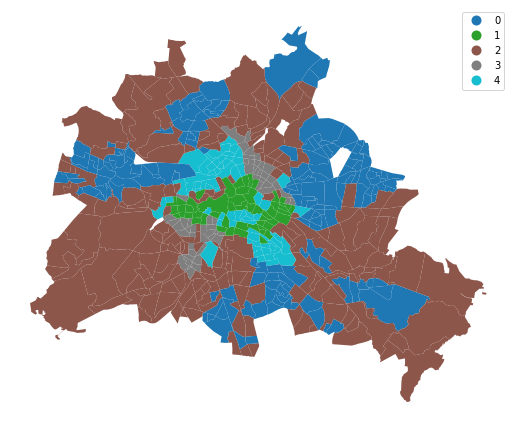

In [8]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)
# Set the seed for reproducibility
np.random.seed(1234)
# Run K-Means algorithm
k5cls = kmeans.fit(db_scaled)
# Assign labels into a column
selected["label"] = k5cls.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including
# a legend and with no boundary lines
selected.plot(
    column="label", categorical=True, legend=True, linewidth=0, ax=ax
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

In [9]:
# Index db on cluster ID
tidy_db = selected.set_index("label")
# Keep only variables used for clustering
tidy_db = tidy_db[clusters]
# Stack column names into a column, obtaining
# a "long" version of the dataset
tidy_db = tidy_db.stack()
# Take indices into proper columns
tidy_db = tidy_db.reset_index()
# Rename column names
tidy_db = tidy_db.rename(
    columns={"level_1": "Attribute", 0: "Values"}
)
# Check out result
tidy_db.head()

,label,Attribute,Values
0,2,mig_rate,0.150040
1,2,dyn_unempl,0.770000
2,2,eating,24.000000
3,2,night_life,6.000000
4,2,public_hou,24.830919


In [32]:
# Group table by cluster label, keep the variables used
# for clustering, and obtain their mean
k5means = db_scaled.groupby("label")[clusters].mean()
# Transpose the table and print it rounding each value
# to three decimals
k5means.T.round(3)

AttributeError: 'numpy.ndarray' object has no attribute 'groupby'

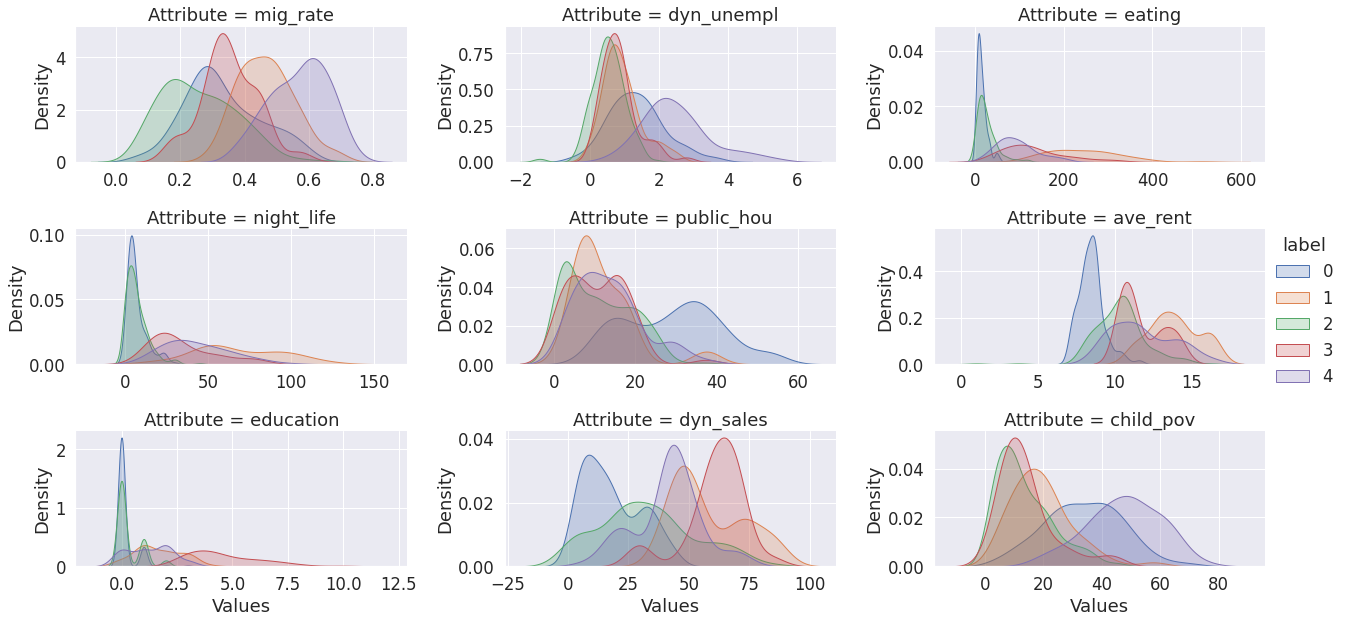

In [10]:
sns.set(font_scale=1.5)
facets = sns.FacetGrid(
    data=tidy_db,
    col="Attribute",
    hue="label",
    sharey=False,
    sharex=False,
    aspect=2,
    col_wrap=3,
)
# Build the plot from `sns.kdeplot`
_ = facets.map(sns.kdeplot, "Values", shade=True).add_legend()

In [12]:
db = libpysal.io.open('../raw_data/labeled.dbf','r')

In [13]:
df = gpd.read_file('../raw_data/labeled.shp')

In [14]:
db

DataTable: ../raw_data/labeled.dbf

In [ ]:
selected

In [46]:
selected.drop(columns=['B_age', ''])

Index(['public_tra', 'eating', 'culture', 'community', 'health_car',
       'public_ser', 'education', 'schools', 'universiti', 'kindergart',
       'outdoor_fa', 'outdoor_le', 'night_life', 'water', 'ave_rent',
       'social_hou', 'public_hou', 'dyn_ew', 'five_y_pls', 'dyn_sales',
       'child_pov', 'dyn_unempl', 'noise', 'air', 'green', 'bio', 'B_age',
       'mig_rate', 'geometry', 'label'],
      dtype='object')

In [18]:
ds_name = "selected.dbf"
y_name = "child_pov"
y = np.array(db.by_col(y_name)).T
y.shape = (len(y),1)
x_names = columns
x = np.array([db.by_col(var) for var in x_names]).T
w = libpysal.weights.Queen.from_dataframe(df)
w_name = "data_q.gal"
w.transform = 'r'    

In [19]:
regimes = db.by_col("label")

In [66]:
#selected.to_file('../raw_data/labeled.shp')

In [15]:
columns = [
    'public_tra', 'eating', 'community', 'education', 'schools', 'kindergart',
    'outdoor_fa', 'outdoor_le', 'night_life', 'ave_rent', 'social_hou',
    'public_hou', 'dyn_ew', 'dyn_sales', 'dyn_unempl', 'noise',
    'air', 'green', 'bio', 'mig_rate'
]

In [18]:
y = np.array(db.by_col('child_pov')).T
x_names = columns
X = np.array([db.by_col(var) for var in x_names]).T

In [38]:
libpysal.weights.Rook.from_dataframe(df).weights

{0: [1.0, 1.0, 1.0, 1.0, 1.0],
 1: [1.0, 1.0, 1.0, 1.0, 1.0],
 2: [1.0, 1.0, 1.0],
 3: [1.0, 1.0, 1.0, 1.0, 1.0],
 4: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 5: [1.0, 1.0, 1.0],
 6: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 7: [1.0, 1.0, 1.0, 1.0, 1.0],
 8: [1.0, 1.0, 1.0, 1.0, 1.0],
 9: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 10: [1.0, 1.0, 1.0],
 11: [1.0, 1.0, 1.0, 1.0],
 12: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 13: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 14: [1.0, 1.0, 1.0, 1.0, 1.0],
 15: [1.0, 1.0, 1.0, 1.0, 1.0],
 16: [1.0, 1.0],
 17: [1.0, 1.0, 1.0, 1.0],
 18: [1.0, 1.0, 1.0, 1.0],
 19: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 20: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 21: [1.0, 1.0, 1.0],
 22: [1.0, 1.0, 1.0, 1.0, 1.0],
 23: [1.0, 1.0, 1.0, 1.0, 1.0],
 24: [1.0, 1.0, 1.0, 1.0, 1.0],
 25: [1.0, 1.0, 1.0, 1.0, 1.0],
 26: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 27: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 28: [1.0, 1.0, 1.0, 1.0, 1.0],
 29: [1.0, 1.0, 1.0, 1.0, 1.0],
 30: [1.0, 1.0, 1.0, 1.0]

In [42]:
mllag = ML_Lag_Regimes(y,
                       X,
                       name_x=columns,
                       name_y='child_pov',
                       regimes=regimes,
                       regime_lag_sep=True,
                       w=libpysal.weights.Rook.from_dataframe(df),
                       name_regimes="label",
                       name_ds='labeled.dbf',
                       name_w='Queen')

/home/maciek/.pyenv/versions/3.8.12/envs/school-map-project/lib/python3.8/site-packages/scipy/optimize/_minimize.py:870: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
/home/maciek/.pyenv/versions/3.8.12/envs/school-map-project/lib/python3.8/site-packages/spreg/ml_lag.py:580: RuntimeWarning: invalid value encountered in log
  jacob = np.log(np.linalg.det(a))


In [43]:
print(mllag.summary)

REGRESSION
----------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG - REGIME 0 (METHOD = full)
----------------------------------------------------------------------------
Data set            : labeled.dbf
Weights matrix      :       Queen
Dependent Variable  : 0_child_pov                Number of Observations:         162
Mean dependent var  :     33.8096                Number of Variables   :          22
S.D. dependent var  :     13.3319                Degrees of Freedom    :         140
Pseudo R-squared    :      0.5105
Spatial Pseudo R-squared:  0.5107
Sigma-square ML     :      86.471                Log likelihood        :    -591.113
S.E of regression   :       9.299                Akaike info criterion :    1226.226
                                                 Schwarz criterion     :    1294.153

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------

In [27]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

In [47]:
mae(selected['child_pov'], mllag.predy.flatten())

4.8123554088217455

In [48]:
np.sqrt(mse(selected['child_pov'], mllag.predy.flatten()))

6.5023327263286514

In [46]:
mllag.multi[0].z_stat

[(2.2910606670966094, 0.02195990512097202),
 (-3.1751444677137273, 0.0014976191972385677),
 (0.5279553238735226, 0.5975303446423436),
 (1.1192000576048455, 0.26305480088787736),
 (-1.9542325688310664, 0.05067371928809022),
 (-0.5692066531382713, 0.569215906137172),
 (-0.3728107214413641, 0.7092893226586808),
 (0.8073065544421159, 0.419489888711271),
 (-2.763761652253827, 0.0057139260355002445),
 (-0.3226589249400797, 0.7469535627499837),
 (-1.0698586418092078, 0.28468294165443386),
 (-0.9749378398395628, 0.3295910946624043),
 (-0.17502663421334305, 0.8610587055334481),
 (1.136989203401092, 0.25554279911107003),
 (1.13566449511291, 0.2560970053383007),
 (1.579251448268386, 0.11427839340598146),
 (-2.2655832462885614, 0.023476911818097565),
 (-0.9356576248699207, 0.3494494949031337),
 (-0.946290749922723, 0.3440003100439466),
 (1.3369572936383505, 0.18123657736871812),
 (7.192630194842387, 6.355491372686466e-13),
 (-0.07577305739003853, 0.9395996515723446)]